![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/4853/media/home_depot_tools.jpg)




# Home Depot Product Search Relevance

After having Great success with characters, we are continuing to a new mission, predicting relevance based on words

# Word Embeddings

In [0]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda, dot
import keras.backend as K
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [0]:
from string import punctuation
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Load files
training_data = pd.read_csv("drive/My Drive/ex3/train.csv", encoding="ISO-8859-1")
testing_data = pd.read_csv("drive/My Drive/ex3/test.csv", encoding="ISO-8859-1")
attribute_data = pd.read_csv('drive/My Drive/ex3/attributes.csv')
descriptions = pd.read_csv('drive/My Drive/ex3/product_descriptions.csv')

test_sol = pd.read_csv('drive/My Drive/ex3/solution.csv')


In [0]:
# Merge descriptions
training_data = pd.merge(training_data, descriptions, 
                         on="product_uid", how="left")

In [0]:
# Merge descriptions
testing_data= pd.merge(testing_data, descriptions, 
                         on="product_uid", how="left")

##Preprocess

### Stemming

We will start by removing punctuation which we found as unnecessary. we will keep some punctuation that we find relevant to the products, such as "*", "/"" and "-"".

In [0]:
from nltk.stem import PorterStemmer


In [0]:
porter = PorterStemmer()


In [0]:
import string
puncList = string.punctuation.replace("/","")
puncList = puncList.replace("-","")
puncList = puncList.replace("_","")
puncList = puncList.replace("*","")

In [0]:
# translator = str.maketrans('', '', puncList)
translator = str.maketrans(puncList, ' '*len(puncList)) #map punctuation to space

In [0]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stops = set(stopwords.words("english"))

def stem_sentences(sentence):     
    tokens = sentence.translate(translator).replace("_","-").split()
    stemmed_tokens = [porter.stem(token) for token in tokens if token.lower() not in stops]
    
    return ' '.join(stemmed_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We are using Porter as our stemmer for stemming the words. stemming the words will decrease the number of different words we have in our corpus and will help us combine similar words which hopefully have the same meaning, just written a little different.

In additionally we removed stop words. Stop words are not useful for us since they cannot imply a real connection between words.

In [0]:
training_data['search_term'] = training_data['search_term'].apply(stem_sentences)

In [0]:
training_data['product_description'] = training_data['product_description'].apply(stem_sentences)

In [0]:
testing_data['search_term'] = testing_data['search_term'].apply(stem_sentences)

In [0]:
testing_data['product_description'] = testing_data['product_description'].apply(stem_sentences)

combining the words from training and test data in order to not have Out-of-vocabulary words when we will test our data. we separated our data for search terms and product description. we believed that there might be a different meaning for words in search terms than in product description, so we wanted to train to different embeddings.

In [0]:
tokenizedSearchWords = [sentence.split() for sentence in training_data['search_term'] ]
tokenizedSearchWords += [sentence.split() for sentence in testing_data['search_term'] ]

In [0]:
tokenizedDescWords = [sentence.split() for sentence in training_data['product_description'] ]
tokenizedDescWords += [sentence.split() for sentence in testing_data['product_description'] ]

Lets get some statistics over our corpus in order to find the best parameters for our model.

In [0]:
sumA = []
counter = 0
for x in tokenizedSearchWords:
    for word in x:
        sumA.append(word)
        
unique = set(sumA)
print("total words in search term", len(sumA))
print("unique words in search term:", len(unique))

total words in search term 565002
unique words in search term: 11126


In [0]:
sumA = []
counter = 0
for x in tokenizedDescWords:
    for word in x:
        sumA.append(word)
        
unique = set(sumA)
print("total words in product description", len(sumA))
print("unique words in product description:", len(unique))

total words in product description 17560841
unique words in product description: 270636


###Word2Vec training

Here we can either use a pre-trained one like Word2Vec and GloVe or train a new one from our text. <br>
The pre-trained will know better connections between words in general while our new trained will be better at connection in  Home Depot item texts.


We've used Word2Vec algorithm for our words embedding.
running it on separately on both search term and product description.
We chose 128 dimensions for the search term since it had significantly fewer words than there was in product description. we chose 256 as the dimension size for product description.

In [0]:
%%time
from gensim.models import word2vec

word2vecModelSearch = word2vec.Word2Vec(tokenizedSearchWords, min_count=1, size=128)

CPU times: user 9.71 s, sys: 56.1 ms, total: 9.76 s
Wall time: 5.72 s


In [0]:
%%time
from gensim.models import word2vec

word2vecModelDesc = word2vec.Word2Vec(tokenizedDescWords, min_count=1, size=256)

CPU times: user 6min 58s, sys: 1.25 s, total: 6min 59s
Wall time: 3min 39s


visualize embedding using TSNE

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


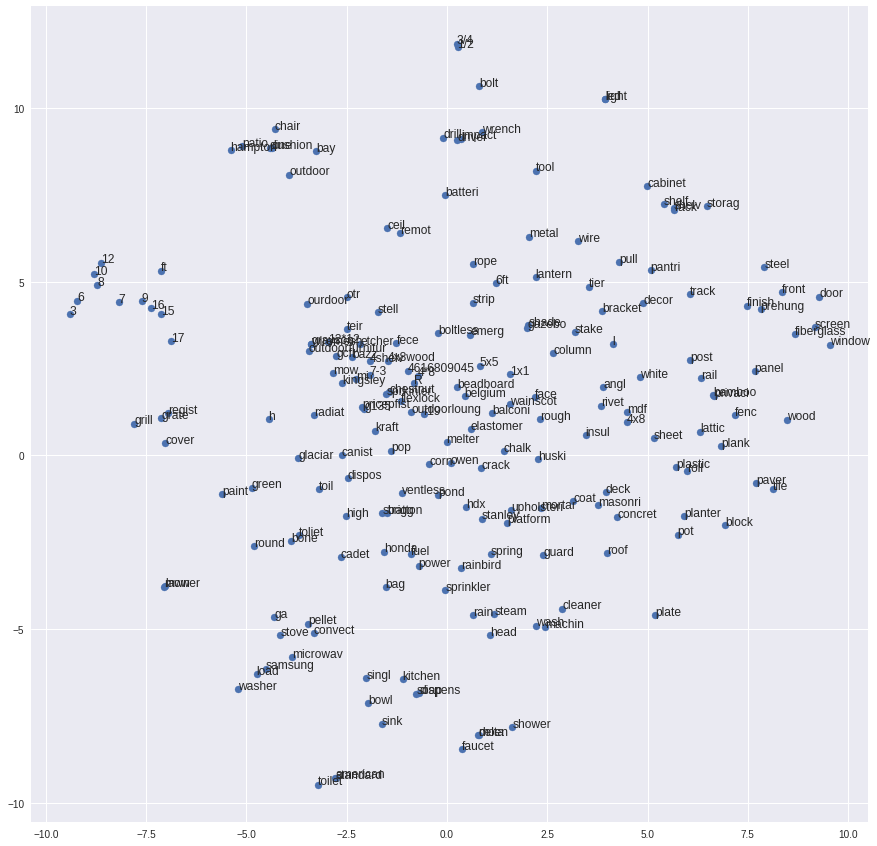

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocab = list(word2vecModelSearch.wv.vocab)[:200]
X = word2vecModelSearch[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)

plt.show()    

# plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
# plt.show()


we can see reasonable connection in our search terms embedding. for example, we can see that the numbers are all fit together. we can see that shelf is close to shelv which is a word that the stemmer created, as well as cabinet and storag. another connection is window with fiberglass and screen which also make sense.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


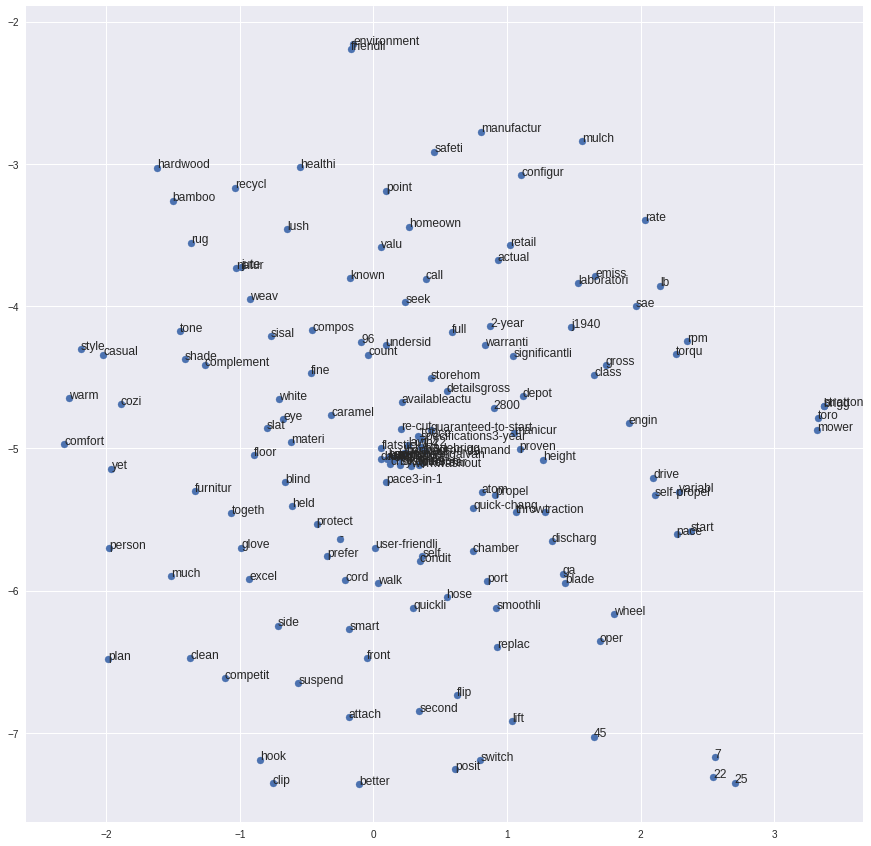

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocab = list(word2vecModelDesc.wv.vocab)[500:650]
X = word2vecModelDesc[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)

plt.show()    

# plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
# plt.show()


In the product description embedding, it's a little harder to see the clear connection. This might be due the fact that there is a lot more words in product description than there is in search term, which might make it harder for model to find clear connection. We also think it can happen because of the bigger embedding dimension, but we tested them on the same dimension size, and got similar results.
We also tried increase the number of iterations from the default Word2Vec of 5 iterations to 10 and 20, but the results only got worse, probably because of overfitting.

To further test our embedding we can get most similar words to a word in the model and see if they make sense.

In [0]:
word2vecModelDesc.most_similar('closet')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pantri', 0.4931899309158325),
 ('mudroom', 0.4201435446739197),
 ('closetmaid', 0.41283082962036133),
 ('staircasesmot', 0.39877423644065857),
 ('wardrob', 0.39064064621925354),
 ('4-shelf', 0.3786293864250183),
 ('hallway', 0.3768250346183777),
 ('superslid', 0.37292543053627014),
 ('shelf', 0.36965039372444153),
 ('shelv', 0.36569225788116455)]

In [0]:
word2vecModelSearch.most_similar('hammer')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('demolit', 0.9257622957229614),
 ('rotari', 0.9107403755187988),
 ('ion', 0.8989611864089966),
 ('drill/driv', 0.8936338424682617),
 ('9/32', 0.8910439014434814),
 ('hammerdril', 0.8903762698173523),
 ('rotomartillo', 0.8854515552520752),
 ('brushless', 0.8837772011756897),
 ('18v', 0.8816567659378052),
 ('roter', 0.875399649143219)]

![alt text](https://images.homedepot-static.com/productImages/07506fd4-04e5-4a48-9249-2707a18975c2/svn/bosch-demolition-breaker-hammers-11335k-64_1000.jpg)
Demolition & Breaker Hammers. our stemmer removed the ion end

![rotary tools](https://images.homedepot-static.com/productImages/da8917e1-79db-4b9c-aa64-bdd42f6cdc38/svn/dremel-rotary-tools-200-1-15-64_1000.jpg, height = 10, width = 10)
 Rotary tools. our stemmer replace "y" with "i"



Here we can see that similar words in both model are pretty good. some of the name of those items are related .

**Saving files**

In [0]:
training_data.to_csv('drive/My Drive/stemmed_training_data.csv')

In [0]:
testing_data.to_csv('drive/My Drive/stemmed_testing_data.csv')

In [0]:
filename = 'embedding_word2vecModelSearch300StemLast'
word2vecModelSearch.wv.save('drive/My Drive/' + filename)

In [0]:
filename = 'embedding_word2vecModelDesc300StemLast'
word2vecModelDesc.wv.save('drive/My Drive/' + filename)

**load models**

In [0]:
training_data = pd.read_csv('drive/My Drive/stemmed_training_data.csv')

In [0]:
testing_data = pd.read_csv('drive/My Drive/stemmed_testing_data.csv')            

In [0]:
from gensim.models import KeyedVectors
word2vecModelSearch = KeyedVectors.load('drive/My Drive/embedding_word2vecModelSearch300StemLast')

In [0]:
from gensim.models import KeyedVectors
word2vecModelDesc = KeyedVectors.load('drive/My Drive/embedding_word2vecModelDesc300StemLast')

### Preparing the data



removing null terms. after stemming, a small number of search terms were removed, and endded up with empty search term. We've decided to drop those terms. Just in case, we checked that product description aswell is not empty.

In [0]:
training_data = training_data[training_data['search_term'].notnull()]
training_data = training_data[training_data['product_description'].notnull()]
testing_data = testing_data[testing_data['search_term'].notnull()]
testing_data = testing_data[testing_data['product_description'].notnull()]

Using label encoder for our words. replacing each word to a numerical label.<br>

In [0]:
%%time
# Prepare embedding
vocabularySearch = dict()
inverse_vocabularySearch = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

for index, row in training_data.iterrows():
    q2n = []  # q2n -> numbers representation
    for word in row['search_term'].split(' '):
        # Check for unwanted words
        if word not in word2vecModelSearch.wv.vocab:
            continue
            
        if word not in vocabularySearch:
            vocabularySearch[word] = len(inverse_vocabularySearch)
            q2n.append(len(inverse_vocabularySearch))
            inverse_vocabularySearch.append(word)
        else:
            q2n.append(vocabularySearch[word])

    # Replace questions as word to question as number representation
    training_data.set_value(index, 'search_term', q2n)     

    

for index, row in testing_data.iterrows():
    q2n = []  # q2n -> numbers representation
    for word in row['search_term'].split(' '):
        # Check for unwanted words
        if word not in word2vecModelSearch.wv.vocab:
            continue
            
        if word not in vocabularySearch:
            vocabularySearch[word] = len(inverse_vocabularySearch)
            q2n.append(len(inverse_vocabularySearch))
            inverse_vocabularySearch.append(word)
        else:
            q2n.append(vocabularySearch[word])

    # Replace questions as word to question as number representation
    testing_data.set_value(index, 'search_term', q2n)   


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


CPU times: user 20 s, sys: 0 ns, total: 20 s
Wall time: 20 s


In [0]:
%%time
# Prepare embedding
vocabularyDesc = dict()
inverse_vocabularyDesc = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

for index, row in training_data.iterrows():
    q2n = []  # q2n -> numbers representation
    for word in row['product_description'].split(' '):
        # Check for unwanted words
        if word not in word2vecModelDesc.wv.vocab:
            continue
            
        if word not in vocabularyDesc:
            vocabularyDesc[word] = len(inverse_vocabularyDesc)
            q2n.append(len(inverse_vocabularyDesc))
            inverse_vocabularyDesc.append(word)
        else:
            q2n.append(vocabularyDesc[word])

    # Replace questions as word to question as number representation
    training_data.set_value(index, 'product_description', q2n)

for index, row in testing_data.iterrows():
    q2n = []  # q2n -> numbers representation
    for word in row['product_description'].split(' '):
        # Check for unwanted words
        if word not in word2vecModelDesc.wv.vocab:
            continue
            
        if word not in vocabularyDesc:
            vocabularyDesc[word] = len(inverse_vocabularyDesc)
            q2n.append(len(inverse_vocabularyDesc))
            inverse_vocabularyDesc.append(word)
        else:
            q2n.append(vocabularyDesc[word])

    # Replace questions as word to question as number representation
    testing_data.set_value(index, 'product_description', q2n)            


    
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


CPU times: user 1min 17s, sys: 0 ns, total: 1min 17s
Wall time: 1min 17s


Next, we need to create the embedding matrix out of our trained word2Vec model

In [0]:
embedding_dimSearch = 128
embeddingsSearch = 1 * np.random.randn(len(vocabularySearch) + 1, embedding_dimSearch)  # This will be the embedding matrix
embeddingsSearch[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabularySearch.items():
    if word in word2vecModelSearch.wv.vocab:
        embeddingsSearch[index] = word2vecModelSearch.wv.word_vec(word)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [0]:
embedding_dimDesc = 256
embeddingsDesc = 1 * np.random.randn(len(vocabularyDesc) + 1, embedding_dimDesc)  # This will be the embedding matrix
embeddingsDesc[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabularyDesc.items():
    if word in word2vecModelDesc.wv.vocab:
        embeddingsDesc[index] = word2vecModelDesc.wv.word_vec(word)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


**Saving embedding matrices**

In [0]:
np.save("drive/My Drive/embeddingsSearchWords.npy", embeddingsSearch)
np.save("drive/My Drive/embeddingsDescWords.npy", embeddingsDesc)

**Loading embedding matrices**

In [0]:
embeddingsSearch = np.load("drive/My Drive/embeddingsSearchWords.npy")
embeddingsDesc = np.load("drive/My Drive/embeddingsDescWords.npy")
embedding_dimDesc = 256
embedding_dimSearch = 128

Creating dictionary from data for working with siamese network and splitting data to validation and training.

In [0]:
cols = ['search_term', 'product_description']

In [0]:
X = training_data[cols]

In [0]:
Y = training_data['relevance']

In [0]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

In [0]:
# Split to dicts
X_train = {'left': X_train.search_term, 'right': X_train.product_description}
X_validation = {'left': X_validation.search_term, 'right': X_validation.product_description}

In [0]:
# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

Same as characters, we would like to get some statistics over search term and description

In [0]:
sumA = 0
maxA = 0
index = 0
for x in training_data.search_term:
    index += 1
    if len(x) == 0:
        print(index)
        sum0 += 1
    if sumA ==0:
        minA = len(x)
    sumA += len(x)
    if len(x) > maxA:
        maxA = len(x)
    if len(x) < minA:
        minA = len(x)
        
print(f'mean: {sumA / len(training_data.search_term)}')
print(f'max: {maxA}')
print(f'min: {minA}')

mean: 3.0396910070630816
max: 11
min: 1


In [0]:
sumA = 0
maxA = 0
for x in training_data.product_description:
    if sumA ==0:
        minA = len(x)
    sumA += len(x)
    if len(x) > maxA:
        maxA = len(x)
    if len(x) < minA:
        minA = len(x)
    

print(f'mean: {sumA / len(training_data)}')
print(f'max: {maxA}')
print(f'min: {minA}')

mean: 94.03085877888368
max: 687
min: 17


And again pad sequences, here we took the max of search term length and a bit bigger then the mean for description.

In [0]:
#TODO: think about padding mean instead of zero
# maxSearchLength = 60
# maxDescLength = 5516
maxSearchLength = 11
maxDescLength = 160

# Zero padding
X_train['left'] = pad_sequences(X_train['left'], maxlen=maxSearchLength )
X_train['right'] = pad_sequences(X_train['right'], maxlen=maxDescLength )
X_validation['left'] = pad_sequences(X_validation['left'],  maxlen=maxSearchLength)
X_validation['right'] = pad_sequences(X_validation['right'],  maxlen=maxDescLength)


# Make sure everything is ok
assert len(X_train['left']) == len(Y_train)
assert len(X_validation['left']) == len(Y_validation)

##Training models


In [0]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/weights.word_embed_stem_diff_1_2.df5', 
                                   verbose=1, save_best_only=True)

We've tried to put the number of hidden units for search to be 11 as the max sequence legnth is 11, and after that layer another dense layer with 64 units to get a similar vector to description vector of the model.<br>
Later we figured our that it wasnt the right choice and we can set the number of hidden units to higher number.

In [0]:
%%time
# Model variables
leftN_hidden = 11
rightN_hidden = 64
batch_size = 64
n_epoch = 10

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


left_output = Dense(64, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_output, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59253 samples, validate on 14814 samples
Epoch 1/10
59253/59253 [==============================] - 296s 5ms/step - loss: 0.2975 - val_loss: 0.2721

Epoch 00001: val_loss improved from inf to 0.27212, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2.df5
Epoch 2/10
59253/59253 [==============================] - 296s 5ms/step - loss: 0.2633 - val_loss: 0.2660

Epoch 00002: val_loss improved from 0.27212 to 0.26602, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2.df5
Epoch 3/10
59253/59253 [==============================] - 296s 5ms/step - loss: 0.2534 - val_loss: 0.2653

Epoch 00003: val_loss improved from 0.26602 to 0.26531, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2.df5
Epoch 4/10
59253/59253 [==============================] - 294s 5ms/step - loss: 0.2440 - val_loss: 0.2624

Epoch 00004: val_loss improved from 0.26531 to 0.26238, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2.df5
Epoch 5/10
59253/59253 [======

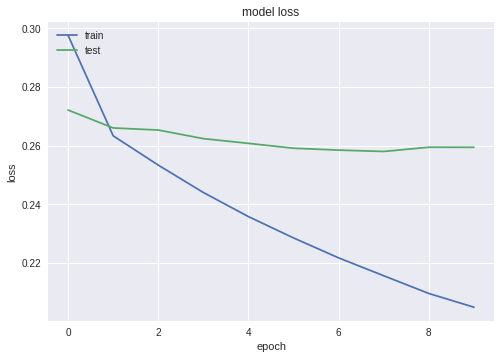

In [0]:
plt.plot(cos_trained.history['loss'])
plt.plot(cos_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

that method was not so good, we've read that it might be better to increase hidden units for LSTM, and add regularizations to reduce overfitting.

###Dropout

We've seen that our model is overfitting after a few epochs. In order to reduce the variance we have added some dropout. From what we've read online, it seems that dropout layers might no be that good after LSTM layer because it can hurt the memory cells. We came accross recurrent dropout and thought we might give it a try.

In [0]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/weights.word_embed_stem_diff_1_2_128hid_drop_last.df5', 
                                   verbose=1, save_best_only=True)

**recurrent_dropout try:**

In [0]:
%%time
# Model variables
leftN_hidden = 128
rightN_hidden = 128
gradient_clipping_norm = 1.25
batch_size = 128
n_epoch = 5

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform', recurrent_dropout=0.4)
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform', recurrent_dropout=0.4)

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(256, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59237 samples, validate on 14810 samples
Epoch 1/5
59237/59237 [==============================] - 200s 3ms/step - loss: 0.2941 - val_loss: 0.2638

Epoch 00001: val_loss improved from inf to 0.26379, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_128hid_drop_last.df5
Epoch 2/5
59237/59237 [==============================] - 200s 3ms/step - loss: 0.2607 - val_loss: 0.2581

Epoch 00002: val_loss improved from 0.26379 to 0.25814, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_128hid_drop_last.df5
Epoch 3/5
59237/59237 [==============================] - 201s 3ms/step - loss: 0.2487 - val_loss: 0.2546

Epoch 00003: val_loss improved from 0.25814 to 0.25458, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_128hid_drop_last.df5
Epoch 4/5
59237/59237 [==============================] - 198s 3ms/step - loss: 0.2364 - val_loss: 0.2504

Epoch 00004: val_loss improved from 0.25458 to 0.25040, saving model to drive/My Drive/weights.word_embed_s

In [0]:
n_epoch = 20
batch_size = 256


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 59237 samples, validate on 14810 samples
Epoch 1/20
59237/59237 [==============================] - 101s 2ms/step - loss: 0.2109 - val_loss: 0.2456

Epoch 00001: val_loss improved from 0.24831 to 0.24559, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_128hid_drop_last.df5
Epoch 2/20
59237/59237 [==============================] - 100s 2ms/step - loss: 0.2051 - val_loss: 0.2450

Epoch 00002: val_loss improved from 0.24559 to 0.24501, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_128hid_drop_last.df5
Epoch 3/20
59237/59237 [==============================] - 99s 2ms/step - loss: 0.2004 - val_loss: 0.2441

Epoch 00003: val_loss improved from 0.24501 to 0.24406, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_128hid_drop_last.df5
Epoch 4/20
59237/59237 [==============================] - 100s 2ms/step - loss: 0.1961 - val_loss: 0.2426

Epoch 00004: val_loss improved from 0.24406 to 0.24257, saving model to drive/My Drive/weights.word_

In [0]:
cos_model.load_weights('drive/My Drive/weights.word_embed_stem_diff_1_2_128hid_drop_last.df5')


In [0]:
n_epoch = 20
batch_size = 512


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 59237 samples, validate on 14810 samples
Epoch 1/20
59237/59237 [==============================] - 51s 858us/step - loss: 0.1603 - val_loss: 0.2397

Epoch 00001: val_loss did not improve from 0.23847
Epoch 2/20
59237/59237 [==============================] - 51s 861us/step - loss: 0.1576 - val_loss: 0.2398

Epoch 00002: val_loss did not improve from 0.23847
Epoch 3/20
59237/59237 [==============================] - 52s 872us/step - loss: 0.1558 - val_loss: 0.2418

Epoch 00003: val_loss did not improve from 0.23847
Epoch 4/20
59237/59237 [==============================] - 51s 865us/step - loss: 0.1543 - val_loss: 0.2398

Epoch 00004: val_loss did not improve from 0.23847
Epoch 5/20
59237/59237 [==============================] - 50s 852us/step - loss: 0.1535 - val_loss: 0.2399

Epoch 00005: val_loss did not improve from 0.23847
Epoch 6/20
59237/59237 [==============================] - 51s 854us/step - loss: 0.1523 - val_loss: 0.2410

Epoch 00006: val_loss did not improve from 0.23

Nice! we got some improvment and managed to lower the overfitting in our model.<br>
We belive we can do a little better and reduce even more the overfitting.

##Winning model

After tweaking the following list of parameters:
- improve network design
    - more memory for lstm
    - more dense layers and dropouts if overfit will happen
    - increase padding to have longer sentences (down side is it will cause also for some sentences to have more zero words at the begining )
    - fit to unNormalized value

We finally found our winning model, we decided not to add any dense layers and treat the overfitting we saw earlier with dropouts in the LSTM layer.
Also, we increased LSTM memory and trained model in growing batches.


We replaced the reccurent dropout with dropout of 0.6 in the lstm mode. From our understaning this dropout occur on the input instead of the output in a normal dropout layer.

In [0]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5', 
                                   verbose=1, save_best_only=True)

In [0]:
%%time
# Model variables
leftN_hidden = 128
rightN_hidden = 128
gradient_clipping_norm = 1.25
batch_size = 256
n_epoch = 30

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform', dropout = 0.6)
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform', dropout = 0.6)

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(256, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59237 samples, validate on 14810 samples
Epoch 1/30
59237/59237 [==============================] - 98s 2ms/step - loss: 0.3909 - val_loss: 0.2704

Epoch 00001: val_loss improved from inf to 0.27040, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 2/30
59237/59237 [==============================] - 98s 2ms/step - loss: 0.2757 - val_loss: 0.2664

Epoch 00002: val_loss improved from 0.27040 to 0.26641, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 3/30
59237/59237 [==============================] - 99s 2ms/step - loss: 0.2727 - val_loss: 0.2646

Epoch 00003: val_loss improved from 0.26641 to 0.26463, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 4/30
59237/59237 [==============================] - 98s 2ms/step - loss: 0.2714 - val_loss: 0.2663

Epoch 00004: val_loss did not improve from 0.26463
Epoch 5/30
59237/59237 [==============================] - 97s 2ms/step - loss: 0

OSError: ignored

some problems with Colab and Drive, we continued where we stopped with the saved weights

In [0]:
n_epoch = 20
batch_size = 256


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 59237 samples, validate on 14810 samples
Epoch 1/20
59237/59237 [==============================] - 98s 2ms/step - loss: 0.2567 - val_loss: 0.2543

Epoch 00001: val_loss did not improve from 0.25418
Epoch 2/20
59237/59237 [==============================] - 99s 2ms/step - loss: 0.2551 - val_loss: 0.2525

Epoch 00002: val_loss improved from 0.25418 to 0.25251, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 3/20
59237/59237 [==============================] - 97s 2ms/step - loss: 0.2533 - val_loss: 0.2510

Epoch 00003: val_loss improved from 0.25251 to 0.25099, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 4/20
59237/59237 [==============================] - 98s 2ms/step - loss: 0.2517 - val_loss: 0.2507

Epoch 00004: val_loss improved from 0.25099 to 0.25071, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 5/20
59237/59237 [==============================] - 100s 2ms/step - lo

Now we see that our model is not overfitting. He's training pretty slow, and our validation model is also improving.
We continue to train this model with different batch size

In [0]:
n_epoch = 20
batch_size = 512


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 59237 samples, validate on 14810 samples
Epoch 1/20
59237/59237 [==============================] - 51s 855us/step - loss: 0.2301 - val_loss: 0.2403

Epoch 00001: val_loss improved from 0.24045 to 0.24026, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 2/20
59237/59237 [==============================] - 52s 875us/step - loss: 0.2299 - val_loss: 0.2399

Epoch 00002: val_loss improved from 0.24026 to 0.23989, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 3/20
59237/59237 [==============================] - 51s 868us/step - loss: 0.2295 - val_loss: 0.2394

Epoch 00003: val_loss improved from 0.23989 to 0.23944, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 4/20
59237/59237 [==============================] - 52s 874us/step - loss: 0.2286 - val_loss: 0.2398

Epoch 00004: val_loss did not improve from 0.23944
Epoch 5/20
59237/59237 [==============================] - 51s 864us/

In [0]:
cos_model.load_weights('drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5')


In [0]:
n_epoch = 20
batch_size = 256


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 59237 samples, validate on 14810 samples
Epoch 1/20
59237/59237 [==============================] - 100s 2ms/step - loss: 0.2286 - val_loss: 0.2392

Epoch 00001: val_loss did not improve from 0.23809
Epoch 2/20
59237/59237 [==============================] - 96s 2ms/step - loss: 0.2279 - val_loss: 0.2407

Epoch 00002: val_loss did not improve from 0.23809
Epoch 3/20
59237/59237 [==============================] - 96s 2ms/step - loss: 0.2274 - val_loss: 0.2391

Epoch 00003: val_loss did not improve from 0.23809
Epoch 4/20
59237/59237 [==============================] - 99s 2ms/step - loss: 0.2270 - val_loss: 0.2377

Epoch 00004: val_loss improved from 0.23809 to 0.23769, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 5/20
59237/59237 [==============================] - 98s 2ms/step - loss: 0.2262 - val_loss: 0.2380

Epoch 00005: val_loss did not improve from 0.23769
Epoch 6/20
59237/59237 [==============================] - 96s 2ms/step - loss: 0.2

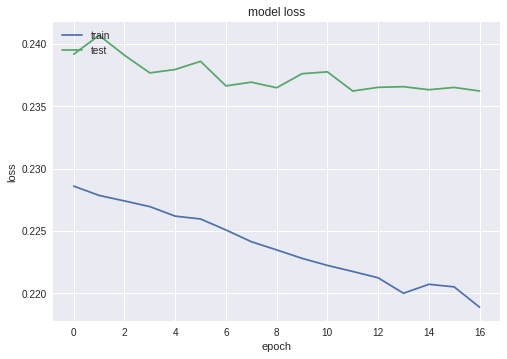

In [0]:
plt.plot(cos_trained.history['loss'])
plt.plot(cos_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The plot seems a bit overfitting, but the numbers are pretty similar, espicially compared to preivous models

In [0]:
cos_model.load_weights('drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5')


In [0]:
n_epoch = 10
batch_size = 1024


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 59237 samples, validate on 14810 samples
Epoch 1/10
59237/59237 [==============================] - 31s 521us/step - loss: 0.2216 - val_loss: 0.2373

Epoch 00001: val_loss did not improve from 0.23624
Epoch 2/10
59237/59237 [==============================] - 31s 529us/step - loss: 0.2210 - val_loss: 0.2370

Epoch 00002: val_loss did not improve from 0.23624
Epoch 3/10
59237/59237 [==============================] - 31s 521us/step - loss: 0.2206 - val_loss: 0.2368

Epoch 00003: val_loss did not improve from 0.23624
Epoch 4/10
59237/59237 [==============================] - 31s 523us/step - loss: 0.2201 - val_loss: 0.2368

Epoch 00004: val_loss did not improve from 0.23624
Epoch 5/10
59237/59237 [==============================] - 31s 522us/step - loss: 0.2204 - val_loss: 0.2367

Epoch 00005: val_loss did not improve from 0.23624
Epoch 6/10
59237/59237 [==============================] - 31s 523us/step - loss: 0.2196 - val_loss: 0.2366

Epoch 00006: val_loss did not improve from 0.23

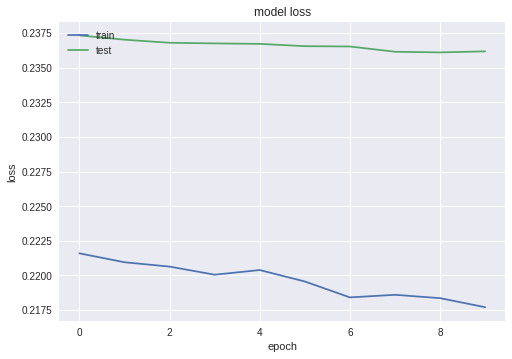

In [0]:
plt.plot(cos_trained.history['loss'])
plt.plot(cos_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
n_epoch = 20
batch_size = 2048

cos_model.load_weights('drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5')
cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 59237 samples, validate on 14810 samples
Epoch 1/20
59237/59237 [==============================] - 24s 399us/step - loss: 0.2177 - val_loss: 0.2360

Epoch 00001: val_loss improved from 0.23610 to 0.23603, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 2/20
59237/59237 [==============================] - 24s 401us/step - loss: 0.2175 - val_loss: 0.2362

Epoch 00002: val_loss did not improve from 0.23603
Epoch 3/20
59237/59237 [==============================] - 23s 396us/step - loss: 0.2175 - val_loss: 0.2361

Epoch 00003: val_loss did not improve from 0.23603
Epoch 4/20
59237/59237 [==============================] - 23s 396us/step - loss: 0.2168 - val_loss: 0.2360

Epoch 00004: val_loss improved from 0.23603 to 0.23599, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5
Epoch 5/20
59237/59237 [==============================] - 24s 403us/step - loss: 0.2168 - val_loss: 0.2360

Epoch 00005: val_loss did not improve from

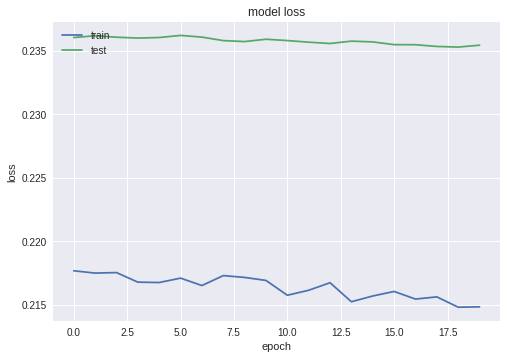

In [0]:
plt.plot(cos_trained.history['loss'])
plt.plot(cos_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
pred_train = cos_model.predict([X_train['left'], X_train['right']])
pred_val = cos_model.predict([X_validation['left'], X_validation['right']])

In [0]:
# predUnNormalized_train = (pred_train *2.0) +1.0

print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))


# predUnNormalized_val = (pred_val *2.0) +1.0

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

Train RMSE score: 0.44158 
Train MAE loss: 0.3573399321716617
Validation RMSE score: 0.48502 
Validation MAE loss: 0.3891330115487654


**This is our best model. It seems like dropout helped. for future work we might try tweaking the dropout and play with it a bit more, maybe combine it with recurrent dropout or by adding a dropout layer  and another dense layers after LSTM**

## Feature Extraction

Now we'll take our best model and use its last layer as features for classic ML model. <br>
We will use the output from the LSTM layers as our features, then train RandomForest and LGBM over that extracted features.

In [0]:
%%time
# Model variables
leftN_hidden = 128
rightN_hidden = 128
gradient_clipping_norm = 1.25
batch_size = 256
n_epoch = 30

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform', dropout = 0.6)
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform', dropout = 0.6)

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(256, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)

CPU times: user 3.46 s, sys: 276 ms, total: 3.73 s
Wall time: 3.45 s


In [0]:
cos_model.load_weights('drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5')

Creating Feature extractor model

In [0]:
featureExtractor = Model(inputs = cos_model.input, outputs = cos_model.get_layer('dot_6').input)

Extracting features for train and Val

In [0]:
predFeatures = featureExtractor.predict([X_train['left'], X_train['right']])

In [0]:
predFeaturesTrain = np.concatenate((predFeatures[0], predFeatures[1]), axis=1)

In [0]:
predFeatures = featureExtractor.predict([X_validation['left'], X_validation['right']])
predFeaturesVal = np.concatenate((predFeatures[0], predFeatures[1]), axis=1)

### Random Forest

In [0]:
%%time
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators = 50, max_depth = 10)
forest.fit(predFeaturesTrain, Y_train)
# save the model to disk
RFfilename = 'drive/My Drive/RandomForestFeatureExtractorWords.sav'
joblib.dump(forest, RFfilename)

CPU times: user 5min 9s, sys: 0 ns, total: 5min 9s
Wall time: 5min 9s


In [0]:
pred_train = forest.predict(predFeaturesTrain)
pred_val = forest.predict(predFeaturesVal)

In [0]:
print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

Train RMSE score: 0.41886 
Train MAE loss: 0.34378421330345227
Validation RMSE score: 0.47857 
Validation MAE loss: 0.3858967300246183


### LightGBM

In [0]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

In [0]:
import lightgbm as lgb

trn_data = lgb.Dataset(predFeaturesTrain, label=Y_train)
val_data = lgb.Dataset(predFeaturesVal, label=Y_validation)

num_round = 11000
clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
# save the model to disk
LGBMfilename = 'drive/My Drive/LGBMFeatureExtractorWords.sav'
joblib.dump(clf, LGBMfilename)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.483839	valid_1's rmse: 0.493847
[200]	training's rmse: 0.465928	valid_1's rmse: 0.486675
[300]	training's rmse: 0.455235	valid_1's rmse: 0.48446
[400]	training's rmse: 0.447155	valid_1's rmse: 0.483234
[500]	training's rmse: 0.440652	valid_1's rmse: 0.482445
[600]	training's rmse: 0.435146	valid_1's rmse: 0.481858
[700]	training's rmse: 0.430394	valid_1's rmse: 0.481293
[800]	training's rmse: 0.426197	valid_1's rmse: 0.480785
[900]	training's rmse: 0.422356	valid_1's rmse: 0.480333
[1000]	training's rmse: 0.418872	valid_1's rmse: 0.479926
[1100]	training's rmse: 0.415473	valid_1's rmse: 0.479468
[1200]	training's rmse: 0.41227	valid_1's rmse: 0.479023
[1300]	training's rmse: 0.409262	valid_1's rmse: 0.478725
[1400]	training's rmse: 0.406322	valid_1's rmse: 0.478398
[1500]	training's rmse: 0.403445	valid_1's rmse: 0.478076
[1600]	training's rmse: 0.400699	valid_1's rmse: 0.477821
[1700]	training's rm

['drive/My Drive/LGBMFeatureExtractorWords.sav']

In [0]:
pred_train = clf.predict(predFeaturesTrain, num_iteration=clf.best_iteration)
pred_val = clf.predict(predFeaturesVal, num_iteration=clf.best_iteration)    

In [0]:
print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

Train RMSE score: 0.33069 
Train MAE loss: 0.2682263309842496
Validation RMSE score: 0.47368 
Validation MAE loss: 0.3775500208280462


#Test


As the competition results are published we can now test our models on the real test data set. <br>
We decided to keep the test dataset hidden from us until finishing all work in order to not overfit it.

In [0]:
# Merge descriptions
testing_data= pd.merge(testing_data, test_sol, 
                         on="id", how="left")

As we remember from character testing some of the test dataset is garbage, we deleted it and stemmed all testing data

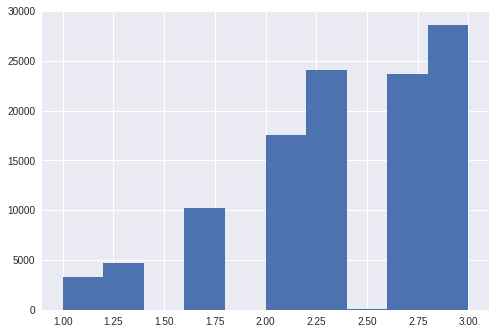

In [0]:
testing_data.relevance.hist()

In [0]:
privateTesting_data = testing_data[testing_data.Usage == 'Private']
publicTesting_data = testing_data[testing_data.Usage == 'Public']

In [0]:
cols = ['search_term', 'product_description']

In [0]:
X_privateTest = privateTesting_data[cols]
X_privateTest = {'left': X_privateTest.search_term, 'right': X_privateTest.product_description}
Y_privateTest = privateTesting_data['relevance']

X_publicTest = publicTesting_data[cols]
X_publicTest = {'left': X_publicTest.search_term, 'right': X_publicTest.product_description}
Y_publicTest = publicTesting_data['relevance']

In [0]:
maxSearchLength = 11
maxDescLength = 160

# Zero padding
X_privateTest['left'] = pad_sequences(X_privateTest['left'], maxlen=maxSearchLength )
X_privateTest['right'] = pad_sequences(X_privateTest['right'], maxlen=maxDescLength )

X_publicTest['left'] = pad_sequences(X_publicTest['left'], maxlen=maxSearchLength )
X_publicTest['right'] = pad_sequences(X_publicTest['right'], maxlen=maxDescLength )

##Testing Siamese network with word LSTM

In [0]:
%%time
# Model variables
leftN_hidden = 128
rightN_hidden = 128
gradient_clipping_norm = 1.25
batch_size = 256
n_epoch = 30

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform', dropout = 0.6)
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform', dropout = 0.6)

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(256, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)

CPU times: user 2.73 s, sys: 240 ms, total: 2.97 s
Wall time: 2.74 s


In [0]:
cos_model.load_weights('drive/My Drive/weights.word_embed_stem_diff_1_2_drop_reg.df5')

In [0]:
pred_privateTest= cos_model.predict([X_privateTest['left'], X_privateTest['right']])

pred_publicTest= cos_model.predict([X_publicTest['left'], X_publicTest['right']])

In [0]:
print('Private Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_privateTest, pred_privateTest))))
print('Private Test MAE loss: {}/n'.format(mean_absolute_error(Y_privateTest, pred_privateTest)))

print('Public Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_publicTest, pred_publicTest))))
print('Public Test MAE loss: {}'.format(mean_absolute_error(Y_publicTest, pred_publicTest)))

Private Test RMSE score: 0.51474 
Private Test MAE loss: 0.4162077370651898/n
Public Test RMSE score: 0.51528 
Public Test MAE loss: 0.4147460820422459


This is the train results:

Train RMSE score: 0.44158 <br>
Train MAE loss: 0.3573399321716617 <br>
Validation RMSE score: 0.48502 <br>
Validation MAE loss: 0.3891330115487654 <br>

So we got a big drop in score by moving to test but the score is still better then the Naive model so we can say that our model did managed to generalize and learn something.



##Testing Siamese network as FE and Random Forest as classifier

In [0]:
%%time
featureExtractor = Model(inputs = cos_model.input, outputs = cos_model.get_layer('dot_6').input)

predFeatures = featureExtractor.predict([X_publicTest['left'], X_publicTest['right']])
predFeaturesPublicTest = np.concatenate((predFeatures[0], predFeatures[1]), axis=1)

predFeatures = featureExtractor.predict([X_privateTest['left'], X_privateTest['right']])
predFeaturesPrivateTest = np.concatenate((predFeatures[0], predFeatures[1]), axis=1)

CPU times: user 13min 13s, sys: 2min 1s, total: 15min 15s
Wall time: 8min 58s


In [0]:
from sklearn.externals import joblib
RFfilename = 'drive/My Drive/RandomForestFeatureExtractorWords.sav'
forest = joblib.load(RFfilename)

In [0]:
pred_PublicTest = forest.predict(predFeaturesPublicTest)
pred_PrivateTest = forest.predict(predFeaturesPrivateTest)

In [0]:
print('Private Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_privateTest, pred_PrivateTest))))
print('Private Test MAE loss: {}/n'.format(mean_absolute_error(Y_privateTest, pred_PrivateTest)))

print('Public Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_publicTest, pred_PublicTest))))
print('Public Test MAE loss: {}/n'.format(mean_absolute_error(Y_publicTest, pred_PublicTest)))

Private Test RMSE score: 0.51792 
Private Test MAE loss: 0.420149152297301/n
Public Test RMSE score: 0.51791 
Public Test MAE loss: 0.4186222166201902/n


Same result as the original neural net, even a little bit worse.

##Testing Siamese network as FE and LightGBM as classifier

In [0]:
from sklearn.externals import joblib
LGBMfilename = 'drive/My Drive/LGBMFeatureExtractorWords.sav'

clf = joblib.load(LGBMfilename)

In [0]:
pred_PublicTest = clf.predict(predFeaturesPublicTest, num_iteration=clf.best_iteration)    
pred_PrivateTest = clf.predict(predFeaturesPrivateTest, num_iteration=clf.best_iteration)    

In [0]:
print('Private Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_privateTest, pred_PrivateTest))))
print('Private Test MAE loss: {}/n'.format(mean_absolute_error(Y_privateTest, pred_PrivateTest)))

print('Public Test RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_publicTest, pred_PublicTest))))
print('Public Test MAE loss: {}/n'.format(mean_absolute_error(Y_publicTest, pred_PublicTest)))

Private Test RMSE score: 0.51829 
Private Test MAE loss: 0.4179236165328734/n
Public Test RMSE score: 0.51866 
Public Test MAE loss: 0.41647237228579137/n


Same as Random Forest and even worse than it, very surprising we have to say.

#Conclusion

In conclusion the best model was the original siamese like network. <br>
We found that altough classical ML improved alot, training and validation score it didnt help generalize to the test set.<br>
For future work we think maybe adding dense layers followed by dropout layers could improve both Siamese model and FE models. <br>
understanding and applying better dropout methods inside LSTM layers could also help the model. <br>
Another key idea that we feel could be more researhced is using pretrained embedding layer like GloVe and FastText.


# Pool of lost ideas

In [0]:
%%time
# Model variables
leftN_hidden = 50 
rightN_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 50

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(128)(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 14067 samples
Epoch 1/50
60000/60000 [==============================] - 327s 5ms/step - loss: 0.2860 - val_loss: 0.2676

Epoch 00001: val_loss improved from inf to 0.26764, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300.df5
Epoch 2/50
60000/60000 [==============================] - 324s 5ms/step - loss: 0.2564 - val_loss: 0.2600

Epoch 00002: val_loss improved from 0.26764 to 0.26004, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300.df5
Epoch 3/50
60000/60000 [==============================] - 325s 5ms/step - loss: 0.2437 - val_loss: 0.2556

Epoch 00003: val_loss improved from 0.26004 to 0.25563, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300.df5
Epoch 4/50
60000/60000 [==============================] - 322s 5ms/step - loss: 0.2331 - val_loss: 0.2538

Epoch 00004: val_loss improved from 0.25563 to 0.25382, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300.df5
Epoch 5/50
60000/6

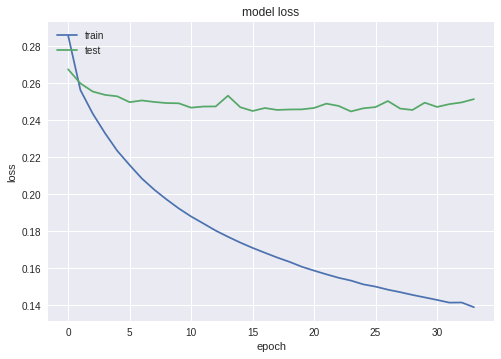

In [0]:
plt.plot(cos_trained.history['loss'])
plt.plot(cos_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# predUnNormalized_train = (pred_train *2.0) +1.0

print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))


# predUnNormalized_val = (pred_val *2.0) +1.0

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

Train RMSE score: 0.37766 
Train MAE loss: 0.3075925295106967
Validation RMSE score: 0.49485 
Validation MAE loss: 0.40151656177580003


In [0]:
%%time
# Model variables
leftN_hidden = 50
rightN_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 512
n_epoch = 30

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dim, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dim, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(128)(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 14067 samples
Epoch 1/30
60000/60000 [==============================] - 51s 846us/step - loss: 0.3523 - val_loss: 0.2700

Epoch 00001: val_loss improved from inf to 0.26996, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300All.df5
Epoch 2/30
60000/60000 [==============================] - 51s 847us/step - loss: 0.2667 - val_loss: 0.2641

Epoch 00002: val_loss improved from 0.26996 to 0.26410, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300All.df5
Epoch 3/30
60000/60000 [==============================] - 49s 824us/step - loss: 0.2572 - val_loss: 0.2624

Epoch 00003: val_loss improved from 0.26410 to 0.26244, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300All.df5
Epoch 4/30
60000/60000 [==============================] - 49s 822us/step - loss: 0.2490 - val_loss: 0.2595

Epoch 00004: val_loss improved from 0.26244 to 0.25948, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300All.df5
Ep

In [0]:
# predUnNormalized_train = (pred_train *2.0) +1.0

print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))


# predUnNormalized_val = (pred_val *2.0) +1.0

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

Train RMSE score: 0.40875 
Train MAE loss: 0.33500437011392914
Validation RMSE score: 0.49934 
Validation MAE loss: 0.4089857647557447


In [0]:
%%time
# Model variables
leftN_hidden = 150
rightN_hidden = 150
gradient_clipping_norm = 1.25
batch_size = 512
n_epoch = 30

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dim, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dim, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(128)(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 14067 samples
Epoch 1/30
60000/60000 [==============================] - 53s 875us/step - loss: 0.3260 - val_loss: 0.2654

Epoch 00001: val_loss did not improve from 0.24934
Epoch 2/30
60000/60000 [==============================] - 51s 852us/step - loss: 0.2639 - val_loss: 0.2659

Epoch 00002: val_loss did not improve from 0.24934
Epoch 3/30
60000/60000 [==============================] - 51s 847us/step - loss: 0.2552 - val_loss: 0.2576

Epoch 00003: val_loss did not improve from 0.24934
Epoch 4/30
60000/60000 [==============================] - 51s 848us/step - loss: 0.2453 - val_loss: 0.2540

Epoch 00004: val_loss did not improve from 0.24934
Epoch 5/30
60000/60000 [==============================] - 51s 847us/step - loss: 0.2356 - val_loss: 0.2531

Epoch 00005: val_loss did not improve from 0.24934
Epoch 6/30
60000/60000 [==============================] - 51s 852us/step - loss: 0.2264 - val_loss: 0.2521

Epoch 00006: val_loss did not improve from 0.24

In [0]:
cos_model.load_weights('drive/My Drive/weights.WordEmbeddingToRelavance300AllTest.df5')


In [0]:
pred_train = cos_model.predict([X_train['left'], X_train['right']])
pred_val = cos_model.predict([X_validation['left'], X_validation['right']])

In [0]:
# predUnNormalized_train = (pred_train *2.0) +1.0

print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))


# predUnNormalized_val = (pred_val *2.0) +1.0

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

**hidden = 100, batch = 128, epochs = 30**

In [0]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/weights.word_embed_stem_diff_1_2_100hid_128B.df5', 
                                   verbose=1, save_best_only=True)

In [0]:
%%time
# Model variables
leftN_hidden = 100
rightN_hidden = 100
gradient_clipping_norm = 1.25
batch_size = 128
n_epoch = 30

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(256, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59237 samples, validate on 14810 samples
Epoch 1/30
59237/59237 [==============================] - 156s 3ms/step - loss: 0.2968 - val_loss: 0.2664

Epoch 00001: val_loss improved from inf to 0.26637, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_100hid_128B.df5
Epoch 2/30
59237/59237 [==============================] - 152s 3ms/step - loss: 0.2585 - val_loss: 0.2589

Epoch 00002: val_loss improved from 0.26637 to 0.25894, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_100hid_128B.df5
Epoch 3/30
59237/59237 [==============================] - 153s 3ms/step - loss: 0.2444 - val_loss: 0.2557

Epoch 00003: val_loss improved from 0.25894 to 0.25571, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_100hid_128B.df5
Epoch 4/30
59237/59237 [==============================] - 152s 3ms/step - loss: 0.2314 - val_loss: 0.2531

Epoch 00004: val_loss improved from 0.25571 to 0.25311, saving model to drive/My Drive/weights.word_embed_stem_diff_1_

In [0]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df5', 
                                   verbose=1, save_best_only=True)

padded with 50 for search term, and 50 hidden units

In [0]:
%%time
#TODO: understand N_hidden (input for LSTM)
# Model variables
leftN_hidden = 50
rightN_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 20

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dim, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dim, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(128)(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 14067 samples
Epoch 1/20
60000/60000 [==============================] - 58s 960us/step - loss: 0.3507 - val_loss: 0.2755

Epoch 00001: val_loss improved from inf to 0.27554, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df5
Epoch 2/20
60000/60000 [==============================] - 57s 948us/step - loss: 0.2647 - val_loss: 0.2716

Epoch 00002: val_loss improved from 0.27554 to 0.27161, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df5
Epoch 3/20
60000/60000 [==============================] - 57s 957us/step - loss: 0.2566 - val_loss: 0.2683

Epoch 00003: val_loss improved from 0.27161 to 0.26834, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df5
Epoch 4/20
60000/60000 [==============================] - 57s 953us/step - loss: 0.2493 - val_loss: 0.2658

Epoch 00004: val_loss improved from 0.26834 to 0.26577, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df

There is some overfitting here, and not getting our best result, we will try to improve it

In [0]:
cos_model.load_weights('drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df5')


In [0]:
pred_train = cos_model.predict([X_train['left'], X_train['right']])
pred_val = cos_model.predict([X_validation['left'], X_validation['right']])

In [0]:
# predUnNormalized_train = (pred_train *2.0) +1.0

print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))


# predUnNormalized_val = (pred_val *2.0) +1.0

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

Train RMSE score: 0.42289 
Train MAE loss: 0.3473968652136326
Validation RMSE score: 0.50558 
Validation MAE loss: 0.4122922195198101


In [0]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/weights.WordEmbeddingToRelavance300StemDiffLSTM.df5', 
                                   verbose=1, save_best_only=True)

In [0]:
%%time
# Model variables
leftN_hidden = 14
rightN_hidden = 150
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 5

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dim, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dim, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


left_dense = Dense(150, activation = 'relu')(left_LstmOutput)

# left_output = Dense(128)(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_dense, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 14067 samples
Epoch 1/5
60000/60000 [==============================] - 366s 6ms/step - loss: 0.2802 - val_loss: 0.2698

Epoch 00001: val_loss did not improve from 0.26116
Epoch 2/5
60000/60000 [==============================] - 365s 6ms/step - loss: 0.2610 - val_loss: 0.2635

Epoch 00002: val_loss did not improve from 0.26116
Epoch 3/5
60000/60000 [==============================] - 364s 6ms/step - loss: 0.2518 - val_loss: 0.2581

Epoch 00003: val_loss improved from 0.26116 to 0.25806, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300StemDiffLSTM.df5
Epoch 4/5
60000/60000 [==============================] - 364s 6ms/step - loss: 0.2431 - val_loss: 0.2559

Epoch 00004: val_loss improved from 0.25806 to 0.25586, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300StemDiffLSTM.df5
Epoch 5/5
60000/60000 [==============================] - 364s 6ms/step - loss: 0.2352 - val_loss: 0.2539

Epoch 00005: val_loss improved from 0.25

In [0]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df5', 
                                   verbose=1, save_best_only=True)

padded with 50 for search term, and 50 hidden units

In [0]:
%%time
#TODO: understand N_hidden (input for LSTM)
# Model variables
leftN_hidden = 50
rightN_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 20

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dim, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dim, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(128)(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 14067 samples
Epoch 1/20
60000/60000 [==============================] - 58s 960us/step - loss: 0.3507 - val_loss: 0.2755

Epoch 00001: val_loss improved from inf to 0.27554, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df5
Epoch 2/20
60000/60000 [==============================] - 57s 948us/step - loss: 0.2647 - val_loss: 0.2716

Epoch 00002: val_loss improved from 0.27554 to 0.27161, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df5
Epoch 3/20
60000/60000 [==============================] - 57s 957us/step - loss: 0.2566 - val_loss: 0.2683

Epoch 00003: val_loss improved from 0.27161 to 0.26834, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df5
Epoch 4/20
60000/60000 [==============================] - 57s 953us/step - loss: 0.2493 - val_loss: 0.2658

Epoch 00004: val_loss improved from 0.26834 to 0.26577, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df

There is some overfitting here, and not getting our best result, we will try to improve it

In [0]:
cos_model.load_weights('drive/My Drive/weights.WordEmbeddingToRelavance300Stem.df5')


In [0]:
pred_train = cos_model.predict([X_train['left'], X_train['right']])
pred_val = cos_model.predict([X_validation['left'], X_validation['right']])

In [0]:
# predUnNormalized_train = (pred_train *2.0) +1.0

print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))


# predUnNormalized_val = (pred_val *2.0) +1.0

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

Train RMSE score: 0.42289 
Train MAE loss: 0.3473968652136326
Validation RMSE score: 0.50558 
Validation MAE loss: 0.4122922195198101


In [0]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/weights.WordEmbeddingToRelavance300StemDiffLSTM.df5', 
                                   verbose=1, save_best_only=True)

In [0]:
%%time
# Model variables
leftN_hidden = 14
rightN_hidden = 150
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 5

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dim, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dim, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


left_dense = Dense(150, activation = 'relu')(left_LstmOutput)

# left_output = Dense(128)(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_dense, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 14067 samples
Epoch 1/5
60000/60000 [==============================] - 366s 6ms/step - loss: 0.2802 - val_loss: 0.2698

Epoch 00001: val_loss did not improve from 0.26116
Epoch 2/5
60000/60000 [==============================] - 365s 6ms/step - loss: 0.2610 - val_loss: 0.2635

Epoch 00002: val_loss did not improve from 0.26116
Epoch 3/5
60000/60000 [==============================] - 364s 6ms/step - loss: 0.2518 - val_loss: 0.2581

Epoch 00003: val_loss improved from 0.26116 to 0.25806, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300StemDiffLSTM.df5
Epoch 4/5
60000/60000 [==============================] - 364s 6ms/step - loss: 0.2431 - val_loss: 0.2559

Epoch 00004: val_loss improved from 0.25806 to 0.25586, saving model to drive/My Drive/weights.WordEmbeddingToRelavance300StemDiffLSTM.df5
Epoch 5/5
60000/60000 [==============================] - 364s 6ms/step - loss: 0.2352 - val_loss: 0.2539

Epoch 00005: val_loss improved from 0.25

**hidden = 500, batch = 512, epochs = 3**

In [0]:
%%time
# Model variables
leftN_hidden = 500
rightN_hidden = 500
gradient_clipping_norm = 1.25
batch_size = 512
n_epoch = 3

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


left_output = Dense(500, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_output, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59253 samples, validate on 14814 samples
Epoch 1/3
59253/59253 [==============================] - 87s 1ms/step - loss: 0.3084 - val_loss: 0.2714

Epoch 00001: val_loss did not improve from 0.25801
Epoch 2/3
59253/59253 [==============================] - 85s 1ms/step - loss: 0.2662 - val_loss: 0.2655

Epoch 00002: val_loss did not improve from 0.25801
Epoch 3/3
59253/59253 [==============================] - 85s 1ms/step - loss: 0.2578 - val_loss: 0.2601

Epoch 00003: val_loss did not improve from 0.25801
CPU times: user 3min 38s, sys: 59.1 s, total: 4min 37s
Wall time: 4min 21s


**hidden = 256, batch = 512, epochs = 3**

In [0]:
%%time
# Model variables
leftN_hidden = 256
rightN_hidden = 256
gradient_clipping_norm = 1.25
batch_size = 512
n_epoch = 3

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


left_output = Dense(256, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_output, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59253 samples, validate on 14814 samples
Epoch 1/3
59253/59253 [==============================] - 51s 863us/step - loss: 0.3301 - val_loss: 0.2709

Epoch 00001: val_loss did not improve from 0.25801
Epoch 2/3
59253/59253 [==============================] - 49s 822us/step - loss: 0.2650 - val_loss: 0.2650

Epoch 00002: val_loss did not improve from 0.25801
Epoch 3/3
59253/59253 [==============================] - 49s 824us/step - loss: 0.2565 - val_loss: 0.2604

Epoch 00003: val_loss did not improve from 0.25801
CPU times: user 2min 58s, sys: 27.8 s, total: 3min 26s
Wall time: 2min 33s


**hidden=256, batch = 512**

In [0]:
%%time
# Model variables
leftN_hidden = 256
rightN_hidden = 256
gradient_clipping_norm = 1.25
batch_size = 512
n_epoch = 3

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


left_output = Dense(256, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_output, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59253 samples, validate on 14814 samples
Epoch 1/3
59253/59253 [==============================] - 52s 870us/step - loss: 0.3221 - val_loss: 0.2706

Epoch 00001: val_loss did not improve from 0.25801
Epoch 2/3
59253/59253 [==============================] - 49s 823us/step - loss: 0.2665 - val_loss: 0.2654

Epoch 00002: val_loss did not improve from 0.25801
Epoch 3/3
59253/59253 [==============================] - 49s 825us/step - loss: 0.2574 - val_loss: 0.2600

Epoch 00003: val_loss did not improve from 0.25801
CPU times: user 3min, sys: 28.2 s, total: 3min 28s
Wall time: 2min 35s


**hidden=256, batch = 64**

In [0]:
%%time
# Model variables
leftN_hidden = 256
rightN_hidden = 256
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 3

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


left_output = Dense(256, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_output, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59253 samples, validate on 14814 samples
Epoch 1/3
59253/59253 [==============================] - 292s 5ms/step - loss: 0.2800 - val_loss: 0.2664

Epoch 00001: val_loss did not improve from 0.25801
Epoch 2/3
59253/59253 [==============================] - 290s 5ms/step - loss: 0.2590 - val_loss: 0.2594

Epoch 00002: val_loss did not improve from 0.25801
Epoch 3/3
59253/59253 [==============================] - 289s 5ms/step - loss: 0.2457 - val_loss: 0.2562

Epoch 00003: val_loss improved from 0.25801 to 0.25620, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2.df5
CPU times: user 19min 56s, sys: 2min 23s, total: 22min 20s
Wall time: 14min 46s


In [0]:
%%time
# Model variables
leftN_hidden = 128
rightN_hidden = 128
gradient_clipping_norm = 1.25
batch_size = 512
n_epoch = 3

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


left_output = Dense(128, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_output, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59253 samples, validate on 14814 samples
Epoch 1/3
59253/59253 [==============================] - 40s 678us/step - loss: 0.3540 - val_loss: 0.2715

Epoch 00001: val_loss did not improve from 0.25801
Epoch 2/3
59253/59253 [==============================] - 38s 645us/step - loss: 0.2655 - val_loss: 0.2668

Epoch 00002: val_loss did not improve from 0.25801
Epoch 3/3
59253/59253 [==============================] - 38s 644us/step - loss: 0.2561 - val_loss: 0.2625

Epoch 00003: val_loss did not improve from 0.25801
CPU times: user 2min 37s, sys: 19.8 s, total: 2min 56s
Wall time: 2min 1s


In [0]:
%%time
# Model variables
leftN_hidden = 256
rightN_hidden = 256
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 3

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)

cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59253 samples, validate on 14814 samples
Epoch 1/3
59253/59253 [==============================] - 292s 5ms/step - loss: 0.2810 - val_loss: 0.2697

Epoch 00001: val_loss did not improve from 0.25620
Epoch 2/3
59253/59253 [==============================] - 290s 5ms/step - loss: 0.2597 - val_loss: 0.2586

Epoch 00002: val_loss did not improve from 0.25620
Epoch 3/3
59253/59253 [==============================] - 290s 5ms/step - loss: 0.2472 - val_loss: 0.2546

Epoch 00003: val_loss improved from 0.25620 to 0.25458, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2.df5
CPU times: user 19min 54s, sys: 2min 23s, total: 22min 17s
Wall time: 14min 45s


In [0]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

checkpointer = ModelCheckpoint(filepath='drive/My Drive/weights.word_embed_stem_diff_1_2_256_128B.df5', 
                                   verbose=1, save_best_only=True)

In [0]:
%%time
# Model variables
leftN_hidden = 256
rightN_hidden = 256
gradient_clipping_norm = 1.25
batch_size = 128
n_epoch = 6

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(256, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59237 samples, validate on 14810 samples
Epoch 1/6
59237/59237 [==============================] - 154s 3ms/step - loss: 0.2876 - val_loss: 0.2664

Epoch 00001: val_loss improved from inf to 0.26639, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_256_128B.df5
Epoch 2/6
59237/59237 [==============================] - 150s 3ms/step - loss: 0.2610 - val_loss: 0.2596

Epoch 00002: val_loss improved from 0.26639 to 0.25964, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_256_128B.df5
Epoch 3/6
59237/59237 [==============================] - 152s 3ms/step - loss: 0.2477 - val_loss: 0.2543

Epoch 00003: val_loss improved from 0.25964 to 0.25434, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_256_128B.df5
Epoch 4/6
59237/59237 [==============================] - 151s 3ms/step - loss: 0.2342 - val_loss: 0.2494

Epoch 00004: val_loss improved from 0.25434 to 0.24938, saving model to drive/My Drive/weights.word_embed_stem_diff_1_2_256_128B.df

In [0]:
%%time
# Model variables
leftN_hidden = 256
rightN_hidden = 256
gradient_clipping_norm = 1.25
batch_size = 128
n_epoch = 30

# The visible layer
left_input = Input(shape=(X_train['left'].shape[1],), dtype='int32')
right_input = Input(shape=(X_train['right'].shape[1],), dtype='int32')

embedding_layerLeft = Embedding(len(embeddingsSearch), embedding_dimSearch, weights=[embeddingsSearch], input_length=maxSearchLength, trainable=False)
embedding_layerRight = Embedding(len(embeddingsDesc), embedding_dimDesc, weights=[embeddingsDesc], input_length=maxDescLength, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layerLeft(left_input)
encoded_right = embedding_layerRight(right_input)

# Since this is a siamese network, both sides share the same LSTM
left_lstm = LSTM(leftN_hidden, kernel_initializer='glorot_uniform')
right_lstm = LSTM(rightN_hidden, kernel_initializer='glorot_uniform')

left_LstmOutput = left_lstm(encoded_left)
right_LstmOutput = right_lstm(encoded_right)


# left_output = Dense(256, activation = 'relu')(left_LstmOutput)
# right_output = Dense(128)(right_LstmOutput)


cosine = dot(inputs = [left_LstmOutput, right_LstmOutput], 
                        axes = -1, normalize = True)

norm = Lambda(lambda x: x * 2 + 1)(cosine)


# Pack it all up into a model
cos_model = Model([left_input, right_input], norm)

# Adadelta optimizer, with gradient clipping by norm
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer = Adam()

cos_model.compile(loss='mean_squared_error', optimizer=optimizer)


cos_trained = cos_model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[checkpointer,early_stopping])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 59237 samples, validate on 14810 samples
Epoch 1/30
59237/59237 [==============================] - 152s 3ms/step - loss: 0.2869 - val_loss: 0.2674

Epoch 00001: val_loss did not improve from 0.24434
Epoch 2/30
59237/59237 [==============================] - 152s 3ms/step - loss: 0.2611 - val_loss: 0.2605

Epoch 00002: val_loss did not improve from 0.24434
Epoch 3/30
59237/59237 [==============================] - 151s 3ms/step - loss: 0.2483 - val_loss: 0.2540

Epoch 00003: val_loss did not improve from 0.24434
Epoch 4/30
59237/59237 [==============================] - 152s 3ms/step - loss: 0.2337 - val_loss: 0.2490

Epoch 00004: val_loss did not improve from 0.24434
Epoch 5/30
59237/59237 [==============================] - 151s 3ms/step - loss: 0.2205 - val_loss: 0.2457

Epoch 00005: val_loss did not improve from 0.24434
Epoch 6/30
59237/59237 [==============================] - 152s 3ms/step - loss: 0.2075 - val_loss: 0.2432

Epoch 00006: val_loss improved from 0.24434 to 0.2432

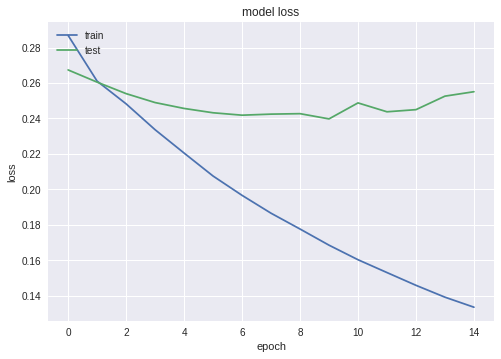

In [0]:
plt.plot(cos_trained.history['loss'])
plt.plot(cos_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [0]:
cos_model.load_weights('drive/My Drive/weights.word_embed_stem_diff_1_2_256_128B.df5')


In [0]:
pred_train = cos_model.predict([X_train['left'], X_train['right']])
pred_val = cos_model.predict([X_validation['left'], X_validation['right']])

In [0]:
# predUnNormalized_train = (pred_train *2.0) +1.0

print('Train RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_train, pred_train))))
print('Train MAE loss: {}'.format(mean_absolute_error(Y_train, pred_train)))


# predUnNormalized_val = (pred_val *2.0) +1.0

print('Validation RMSE score: {:<8.5f}'.format(np.sqrt(mean_squared_error(Y_validation, pred_val))))
print('Validation MAE loss: {}'.format(mean_absolute_error(Y_validation, pred_val)))

Train RMSE score: 0.38880 
Train MAE loss: 0.31861743233685536
Validation RMSE score: 0.48965 
Validation MAE loss: 0.3966052594336201
